In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/speech-emotion-recognition-en/Savee/JE_h09.wav
/kaggle/input/speech-emotion-recognition-en/Savee/KL_f12.wav
/kaggle/input/speech-emotion-recognition-en/Savee/DC_h03.wav
/kaggle/input/speech-emotion-recognition-en/Savee/DC_d04.wav
/kaggle/input/speech-emotion-recognition-en/Savee/KL_a14.wav
/kaggle/input/speech-emotion-recognition-en/Savee/JE_f01.wav
/kaggle/input/speech-emotion-recognition-en/Savee/KL_h15.wav
/kaggle/input/speech-emotion-recognition-en/Savee/JK_su02.wav
/kaggle/input/speech-emotion-recognition-en/Savee/JK_a06.wav
/kaggle/input/speech-emotion-recognition-en/Savee/DC_n01.wav
/kaggle/input/speech-emotion-recognition-en/Savee/DC_f01.wav
/kaggle/input/speech-emotion-recognition-en/Savee/JK_n22.wav
/kaggle/input/speech-emotion-recognition-en/Savee/KL_a10.wav
/kaggle/input/speech-emotion-recognition-en/Savee/JE_n08.wav
/kaggle/input/speech-emotion-recognition-en/Savee/KL_sa13.wav
/kaggle/input/speech-emotion-recognition-en/Savee/DC_a12.wav
/kaggle/input/speech-e

In [2]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout, BatchNormalization


In [3]:
import os

# Định nghĩa đường dẫn dữ liệu
crema_data_path = "/kaggle/input/speech-emotion-recognition-en/Crema"

# Kiểm tra xem thư mục có tồn tại không
if not os.path.isdir(crema_data_path):  # Sử dụng isdir để kiểm tra thư mục
    raise FileNotFoundError(f"Thư mục không tồn tại hoặc không thể truy cập: {crema_data_path}")

# Lấy danh sách tệp âm thanh (.wav)
try:
    all_files = os.listdir(crema_data_path)  # Lấy tất cả file trong thư mục
    audio_files = [os.path.join(crema_data_path, f) for f in all_files if f.lower().endswith('.wav')]
except Exception as e:
    raise RuntimeError(f"Lỗi khi truy cập thư mục: {e}")

# Kiểm tra nếu danh sách tệp rỗng
if not audio_files:
    raise ValueError("Không tìm thấy tệp âm thanh nào trong thư mục CREMA!")

# In thông tin danh sách file
print(f"Tổng số tệp âm thanh hợp lệ: {len(audio_files)}")
print("Ví dụ 5 tệp đầu tiên:", audio_files[:5])

Tổng số tệp âm thanh hợp lệ: 7442
Ví dụ 5 tệp đầu tiên: ['/kaggle/input/speech-emotion-recognition-en/Crema/1028_TSI_DIS_XX.wav', '/kaggle/input/speech-emotion-recognition-en/Crema/1075_IEO_HAP_LO.wav', '/kaggle/input/speech-emotion-recognition-en/Crema/1084_ITS_HAP_XX.wav', '/kaggle/input/speech-emotion-recognition-en/Crema/1067_IWW_DIS_XX.wav', '/kaggle/input/speech-emotion-recognition-en/Crema/1066_TIE_DIS_XX.wav']


In [4]:
!pip install --upgrade seaborn pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 6.3 MB/s eta 0:00:00
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.12.2
    Uninstalling seaborn-0.12.2:
      Successfully uninstalled seaborn-0.12.2


In [5]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

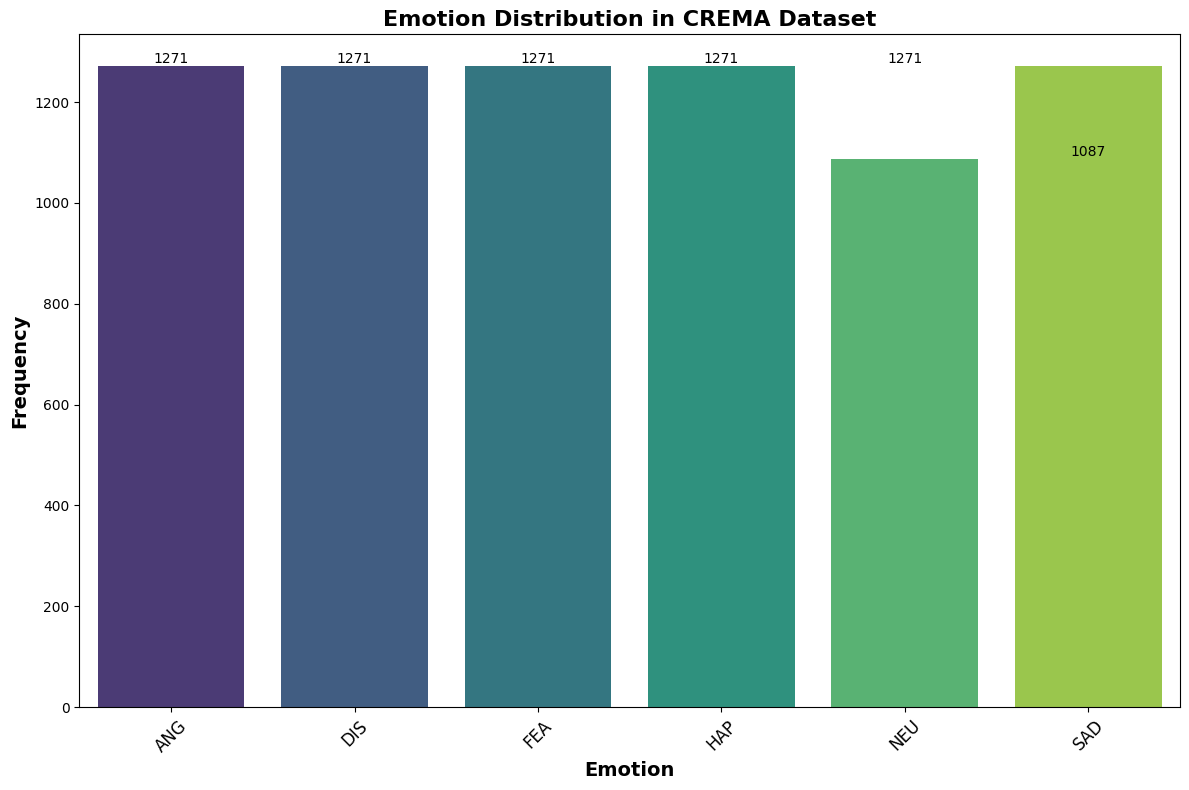

In [6]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Định nghĩa đường dẫn dữ liệu
crema_data_path = "/kaggle/input/speech-emotion-recognition-en/Crema"

# Kiểm tra xem thư mục có tồn tại không
if not os.path.exists(crema_data_path):
    raise FileNotFoundError(f"Thư mục không tồn tại: {crema_data_path}")

# Lấy danh sách tệp âm thanh
audio_files = [os.path.join(crema_data_path, f) for f in os.listdir(crema_data_path) if f.endswith('.wav')]

# Kiểm tra nếu danh sách tệp rỗng
if not audio_files:
    raise ValueError("Không tìm thấy tệp âm thanh nào trong thư mục CREMA!")

# Hàm trích xuất nhãn cảm xúc
def extract_emotion(filename):
    base_name = os.path.basename(filename)  # Lấy tên file không có đường dẫn
    parts = base_name.split('_')
    
    if len(parts) >= 3 and parts[2].isalpha():  # Kiểm tra đúng định dạng
        return parts[2]  # Trả về mã cảm xúc
    return "UNKNOWN"  # Gán nhãn mặc định nếu không hợp lệ

# Ánh xạ cảm xúc từ tên tệp
emotion_labels = [extract_emotion(f) for f in audio_files]

# Kiểm tra phân bố nhãn
label_counts = pd.Series(emotion_labels, dtype="category").value_counts()

# Vẽ biểu đồ phân bố cảm xúc
plt.figure(figsize=(12, 8))
ax = sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")

# Hiển thị số lượng trên từng cột
for i, value in enumerate(label_counts.values):
    ax.text(i, value + 1 if value > 5 else value - 1, 
            f'{value}', ha='center', va='bottom' if value > 5 else 'top', 
            fontsize=10, color='black' if value > 5 else 'white')

# Tiêu đề và nhãn
plt.title("Emotion Distribution in CREMA Dataset", fontsize=16, weight='bold')
plt.xlabel("Emotion", fontsize=14, weight='bold')
plt.ylabel("Frequency", fontsize=14, weight='bold')
plt.xticks(rotation=45, fontsize=12)

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()

In [7]:
import os
import numpy as np
import librosa
import librosa.effects
import librosa.util
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# Tiền xử lý âm thanh
def preprocess_audio(file_path, target_sr=16000, max_length=3):
    if not os.path.exists(file_path):  
        raise FileNotFoundError(f"File không tồn tại: {file_path}")
    
    try:
        audio_signal, sr = librosa.load(file_path, sr=target_sr)
        audio_signal, _ = librosa.effects.trim(audio_signal)
        audio_signal = librosa.util.normalize(audio_signal)

        max_samples = int(target_sr * max_length)
        if len(audio_signal) < max_samples:
            audio_signal = np.pad(audio_signal, (0, max_samples - len(audio_signal)), mode='constant')
        else:
            audio_signal = audio_signal[:max_samples]

        return audio_signal, sr
    except Exception as e:
        print(f"Lỗi khi xử lý tệp {file_path}: {e}")
        return None, None

# Tiền xử lý toàn bộ tập dữ liệu
X = []
y = []

for file in tqdm(audio_files, desc="Processing audio files"):
    emotion = extract_emotion(file)
    audio_signal, _ = preprocess_audio(file)

    if audio_signal is not None:
        X.append(audio_signal)
        y.append(emotion)

X = np.array(X)
y = np.array(y)

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

print(f"Dataset size: {X.shape}")
print(f"Train size: {X_train.shape}, Test size: {X_test.shape}")
print(f"Number of classes: {len(label_encoder.classes_)} - {label_encoder.classes_}")

Processing audio files: 100%|██████████| 7442/7442 [02:41<00:00, 46.08it/s]


Dataset size: (7442, 48000)
Train size: (5953, 48000), Test size: (1489, 48000)
Number of classes: 6 - ['ANG' 'DIS' 'FEA' 'HAP' 'NEU' 'SAD']


In [8]:
!pip install librosa


In [9]:
import os
import librosa
import numpy as np
from tqdm import tqdm

# a. Hàm trích xuất đặc trưng từ tín hiệu âm thanh
def extract_features(signal, sr=16000, n_mfcc=40):
    """
    Trích xuất đặc trưng MFCCs, Chroma, và Mel Spectrogram từ tín hiệu âm thanh.
    - signal: Tín hiệu âm thanh (mảng numpy)
    - sr: Tần số lấy mẫu (mặc định 16kHz)
    - n_mfcc: Số lượng hệ số MFCC cần trích xuất
    """
    # Trích xuất MFCC
    mfccs = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=n_mfcc)
    # Trích xuất Chroma
    chroma = librosa.feature.chroma_stft(y=signal, sr=sr)
    # Trích xuất Mel Spectrogram
    mel_spec = librosa.feature.melspectrogram(y=signal, sr=sr, n_fft=2048, hop_length=512)

    # Kết hợp đặc trưng bằng cách lấy trung bình trên mỗi trục
    feature_vector = np.concatenate([
        np.mean(mfccs, axis=1),
        np.mean(chroma, axis=1),
        np.mean(mel_spec, axis=1)
    ])

    return feature_vector

# b. Tiền xử lý toàn bộ tập dữ liệu và trích xuất đặc trưng
def prepare_feature_dataset(audio_files, labels, sr=16000, max_length=3):
    """
    Tiền xử lý dữ liệu âm thanh và trích xuất đặc trưng từ tập CREMA.
    - audio_files: Danh sách đường dẫn tệp âm thanh
    - labels: Nhãn cảm xúc tương ứng
    - sr: Tần số lấy mẫu (16kHz)
    - max_length: Độ dài tối đa của mỗi tệp (mặc định 3 giây)
    """
    X, y = [], []
    max_samples = int(sr * max_length)  # Số mẫu tối đa dựa trên thời gian

    for i, file_path in tqdm(enumerate(audio_files), total=len(audio_files), desc="Extracting features"):
        # Load và tiền xử lý tín hiệu âm thanh
        signal, _ = librosa.load(file_path, sr=sr)

        # Cắt hoặc đệm tín hiệu về đúng độ dài
        if len(signal) < max_samples:
            signal = np.pad(signal, (0, max_samples - len(signal)), mode='constant')
        else:
            signal = signal[:max_samples]

        # Trích xuất đặc trưng
        feature_vector = extract_features(signal, sr=sr)
        X.append(feature_vector)
        y.append(labels[i])  # Nhãn cảm xúc tương ứng

    return np.array(X), np.array(y)

# c. Định nghĩa đường dẫn tập dữ liệu
crema_data_path = "/kaggle/input/speech-emotion-recognition-en/Crema"

# d. Lấy danh sách file âm thanh (.wav)
audio_files = [os.path.join(crema_data_path, f) for f in os.listdir(crema_data_path) if f.endswith('.wav')]

# e. Mapping mã cảm xúc theo định dạng CREMA
emotion_map = {
    'DIS': 0,  # Disgust
    'HAP': 1,  # Happiness
    'SAD': 2,  # Sadness
    'ANG': 3,  # Anger
    'FEA': 4,  # Fear
    'NEU': 5   # Neutral
}

# f. Trích xuất nhãn từ tên tệp
labels = []
for file in audio_files:
    try:
        emotion_code = os.path.basename(file).split('_')[2]  # Lấy mã cảm xúc từ tên file
        labels.append(emotion_map.get(emotion_code, -1))  # Gán nhãn hoặc -1 nếu không hợp lệ
    except IndexError:
        labels.append(-1)  # Xử lý lỗi nếu tên file không đúng định dạng

# g. Loại bỏ các tệp có nhãn không hợp lệ (-1)
valid_indices = [i for i in range(len(labels)) if labels[i] != -1]
audio_files = [audio_files[i] for i in valid_indices]
labels = [labels[i] for i in valid_indices]

# h. Chuẩn bị tập dữ liệu
X, y = prepare_feature_dataset(audio_files, labels, sr=16000, max_length=3)

# i. Kiểm tra kích thước dữ liệu đầu ra
print(f"Dataset size: {X.shape}, Labels size: {y.shape}")

Extracting features:  90%|████████▉ | 6673/7442 [02:19<00:15, 49.78it/s]/usr/local/lib/python3.10/dist-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
Extracting features: 100%|██████████| 7442/7442 [02:35<00:00, 47.79it/s]

Dataset size: (7442, 180), Labels size: (7442,)


In [10]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Trích xuất đặc trưng và chuẩn bị tập dữ liệu (X, y)
X, y = prepare_feature_dataset(audio_files, labels)

# Chia tập dữ liệu (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# In kích thước của tập dữ liệu sau khi chia
print(f"Training Data Shape: {X_train.shape}")
print(f"Testing Data Shape: {X_test.shape}")

Extracting features: 100%|██████████| 7442/7442 [02:35<00:00, 47.71it/s]

Training Data Shape: (5953, 180)
Testing Data Shape: (1489, 180)


In [11]:
from sklearn.preprocessing import StandardScaler

# Kiểm tra shape của dữ liệu
print("X_train shape before:", X_train.shape)
print("X_test shape before:", X_test.shape)


# Đảm bảo dữ liệu có đúng 3 chiều (num_samples, timesteps, num_features)
if len(X_train.shape) == 2:
    X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

# Lấy shape sau khi đảm bảo đúng định dạng
num_samples, timesteps, num_features = X_train.shape

# Khởi tạo bộ chuẩn hóa
scaler = StandardScaler()

# Reshape về 2D để chuẩn hóa
X_train_reshaped = X_train.reshape(-1, num_features)
X_test_reshaped = X_test.reshape(-1, num_features)

# Áp dụng StandardScaler
X_train_scaled = scaler.fit_transform(X_train_reshaped)
X_test_scaled = scaler.transform(X_test_reshaped)

# Chuyển về lại 3D để dùng với GRU
X_train = X_train_scaled.reshape(num_samples, timesteps, num_features)
X_test = X_test_scaled.reshape(X_test.shape[0], timesteps, num_features)

print("X_train shape after:", X_train.shape)
print("X_test shape after:", X_test.shape)


X_train shape before: (5953, 180)
X_test shape before: (1489, 180)
X_train shape after: (5953, 1, 180)
X_test shape after: (1489, 1, 180)


/usr/local/lib/python3.10/dist-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


Epoch 1/300
187/187 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.2694 - loss: 1.7072 - val_accuracy: 0.2861 - val_loss: 1.6067
Epoch 2/300
187/187 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.2916 - loss: 1.6375 - val_accuracy: 0.3056 - val_loss: 1.5985
Epoch 3/300
187/187 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.3209 - loss: 1.5946 - val_accuracy: 0.3076 - val_loss: 1.6302
Epoch 4/300
187/187 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.3185 - loss: 1.6012 - val_accuracy: 0.3412 - val_loss: 1.5426
Epoch 5/300
187/187 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.3325 - loss: 1.5518 - val_accuracy: 0.3412 - val_loss: 1.5764
Epoch 6/300
187/187 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.3266 - loss: 1.5595 - val_accuracy: 0.3351 - val_loss: 1.5343
Epoch 7/300
187/187 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.3444 - loss: 1.5479 - val_accuracy: 0.3674 - val_loss: 1.5104
Epoch 8/300
187/187 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.3563 - loss: 1.5008 - 

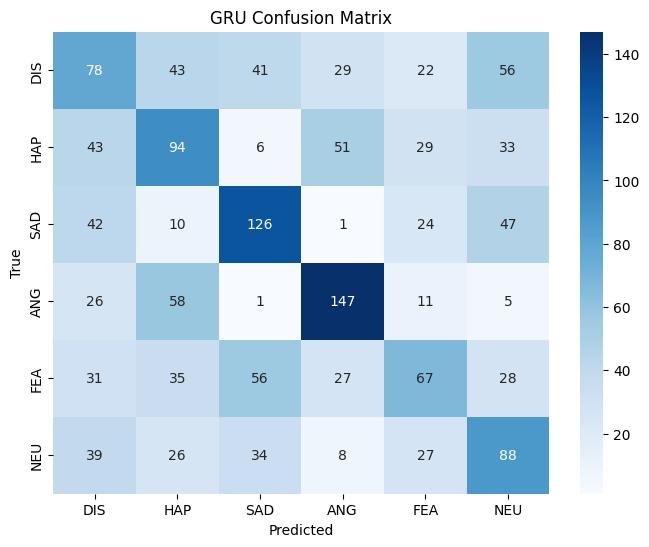

              precision    recall  f1-score   support

         DIS       0.30      0.29      0.30       269
         HAP       0.35      0.37      0.36       256
         SAD       0.48      0.50      0.49       250
         ANG       0.56      0.59      0.58       248
         FEA       0.37      0.27      0.32       244
         NEU       0.34      0.40      0.37       222

    accuracy                           0.40      1489
   macro avg       0.40      0.40      0.40      1489
weighted avg       0.40      0.40      0.40      1489



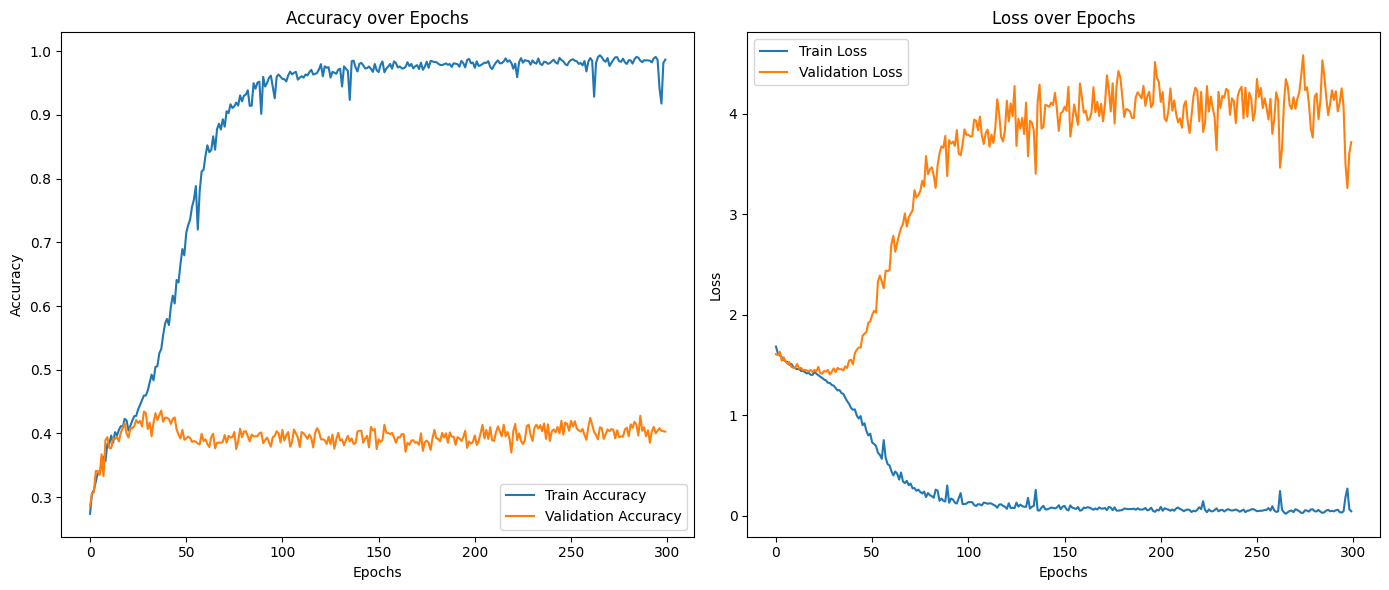

In [12]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout, Input
from keras.optimizers import Adam
from keras.utils import to_categorical
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, classification_report

# Load CREMA dataset
data_path = '/kaggle/input/speech-emotion-recognition-en/Crema'
audio_files = [os.path.join(data_path, f) for f in os.listdir(data_path) if f.endswith('.wav')]

# Emotion mapping
emotion_map = {'DIS': 0, 'HAP': 1, 'SAD': 2, 'ANG': 3, 'FEA': 4, 'NEU': 5}
labels = [emotion_map.get(f.split('_')[2], -1) for f in audio_files]

# Feature extraction
def extract_features(signal, sr=16000, n_mfcc=40):
    mfccs = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=n_mfcc)
    chroma = librosa.feature.chroma_stft(y=signal, sr=sr)
    mel_spec = librosa.feature.melspectrogram(y=signal, sr=sr)
    feature_vector = np.hstack([
        np.mean(mfccs, axis=1),
        np.mean(chroma, axis=1),
        np.mean(mel_spec, axis=1)
    ])
    return feature_vector

# Prepare dataset
def prepare_feature_dataset(audio_files, labels, sr=16000):
    X, y = [], []
    for file_path, label in zip(audio_files, labels):
        signal, _ = librosa.load(file_path, sr=sr)
        X.append(extract_features(signal, sr=sr))
        y.append(label)
    return np.array(X), np.array(y)

X, y = prepare_feature_dataset(audio_files, labels)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape for GRU
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# One-hot encode labels
y_train_encoded = to_categorical(y_train, num_classes=6)
y_test_encoded = to_categorical(y_test, num_classes=6)

# Build GRU model
gru_model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    GRU(256, return_sequences=True),
    Dropout(0.2),
    GRU(128),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(6, activation='softmax')
])

gru_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train model
history = gru_model.fit(X_train, y_train_encoded, epochs=300, batch_size=32, validation_data=(X_test, y_test_encoded))

# Evaluate model
accuracy = gru_model.evaluate(X_test, y_test_encoded)[1] * 100
print(f"GRU Model Accuracy: {accuracy:.2f}%")

# Predictions
y_pred = np.argmax(gru_model.predict(X_test), axis=1)

# Metrics
print(f"F1 Score: {f1_score(y_test, y_pred, average='macro'):.2f}")
print(f"Precision: {precision_score(y_test, y_pred, average='macro'):.2f}")
print(f"Recall: {recall_score(y_test, y_pred, average='macro'):.2f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_map.keys(), yticklabels=emotion_map.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('GRU Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(y_test, y_pred, target_names=emotion_map.keys()))

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].plot(history.history['accuracy'], label='Train Accuracy')
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[0].set_title('Accuracy over Epochs')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(history.history['loss'], label='Train Loss')
axes[1].plot(history.history['val_loss'], label='Validation Loss')
axes[1].set_title('Loss over Epochs')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()

plt.tight_layout()
plt.show()
